In [73]:
import pandas as pd 

df= pd.read_csv("./l_final.csv")

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2720 non-null   object 
 1   location             2719 non-null   object 
 2   date                 2720 non-null   object 
 3   percentage_laid_off  2720 non-null   float64
 4   industry             2718 non-null   object 
 5   source               2720 non-null   object 
 6   stage                2716 non-null   object 
 7   funds_raised         2434 non-null   float64
 8   country              2719 non-null   object 
 9   year                 2720 non-null   int64  
 10  month                2720 non-null   int64  
 11  high_layoff          2720 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 236.5+ KB


In [75]:
X= df.drop(columns=["percentage_laid_off"])
y= df["percentage_laid_off"]


In [76]:
X.drop(columns=["date","source","high_layoff"],inplace=True)

In [77]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       2720 non-null   object 
 1   location      2719 non-null   object 
 2   industry      2718 non-null   object 
 3   stage         2716 non-null   object 
 4   funds_raised  2434 non-null   float64
 5   country       2719 non-null   object 
 6   year          2720 non-null   int64  
 7   month         2720 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 170.1+ KB


In [78]:
# Split chronologically
X_train = X[X['year'] <= 2023]
X_test  = X[X['year'] > 2023]

y_train = y[X['year'] <= 2023]
y_test  = y[X['year'] > 2023]

print(X_train.shape, X_test.shape)


(2204, 8) (516, 8)


In [79]:
import numpy as np

def remove_outliers_iqr(df, cols):
    cleaned = df.copy()
    for col in cols:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned


In [80]:
num_cols = ['funds_raised']
X_train = remove_outliers_iqr(X_train, num_cols)

# Make sure y_train matches the filtered X_train
y_train = y_train.loc[X_train.index]


In [81]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


In [82]:
categorical = ['company', 'location', 'industry', 'stage', 'country']
numerical = ['funds_raised', 'year', 'month']


In [83]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


In [84]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical),
    ('num', num_pipeline, numerical)
])


In [85]:
baseline_pred= [y_train.mean() for i in range(len(y_test))]
print("Baseline Error: ", mean_absolute_error(baseline_pred,y_test))

Baseline Error:  0.2928660487928757


In [86]:
model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


MAE: 0.3812
R²: -1.9160


/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


our model performs poorly and its mean absolute error is greater than the naive model making it a useless model 

In [87]:
categorical_cols = ['company', 'location', 'industry', 'country']

def filter_unseen_categories(X_train, X_test, y_train, y_test, categorical_cols):
    mask = np.ones(len(X_test), dtype=bool)
    
    for col in categorical_cols:
        seen_values = set(X_train[col].unique())
        mask &= X_test[col].isin(seen_values)
    
    X_test_filtered = X_test[mask]
    y_test_filtered = y_test[mask]
    
    print(f"✅ Filtered out {len(X_test) - len(X_test_filtered)} rows with unseen categories.")
    return X_test_filtered, y_test_filtered


what we have done is, we have removed the rows which had unseen data in it like new industries, companies, our model cannot predict for that right

In [88]:
X_test, y_test = filter_unseen_categories(X_train, X_test, y_train, y_test, categorical_cols)


✅ Filtered out 363 rows with unseen categories.


In [89]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 2 to 2637
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       153 non-null    object 
 1   location      153 non-null    object 
 2   industry      153 non-null    object 
 3   stage         153 non-null    object 
 4   funds_raised  151 non-null    float64
 5   country       153 non-null    object 
 6   year          153 non-null    int64  
 7   month         153 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 10.8+ KB


In [90]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


MAE: 0.1841
R²: 0.0743


/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_


Model Interpretation 

In [91]:
# Extract the trained regression model from pipeline
lin_reg = model.named_steps['linearregression']

# Get feature names after encoding/scaling
feature_names = model.named_steps['columntransformer'].get_feature_names_out()

# Combine feature names with coefficients
import pandas as pd
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lin_reg.coef_
})

print("Intercept:", lin_reg.intercept_)
print(coef_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10))


Intercept: 0.16873784237306833
                           Feature  Coefficient
737          cat__company_Madefire     1.268986
877         cat__company_Ozy Media     1.247703
572           cat__company_HubHaus     1.225652
550             cat__company_Heygo     1.209082
502           cat__company_Glisser     1.203745
89     cat__company_Aura Financial     1.140322
858           cat__company_Openpay     1.095402
991             cat__company_Reali     1.087917
788   cat__company_Motif Investing     1.067263
1357          cat__company_Yabonza     1.058781


In [92]:
coef_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1662 entries, 0 to 1661
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature      1662 non-null   object 
 1   Coefficient  1662 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.1+ KB


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_pred


Histogram (Normality check)

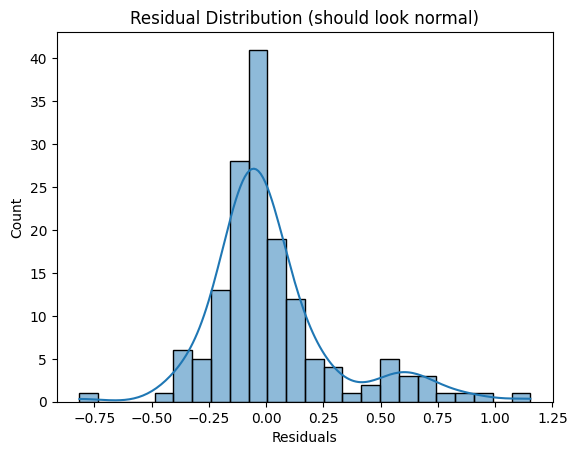

In [94]:
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (should look normal)")
plt.xlabel("Residuals")
plt.show()


This residual distribution appears roughly centered around zero, which is a good sign—it means the model’s predictions don’t systematically overestimate or underestimate the target. However, the curve is slightly right-skewed, with a longer tail on the positive side. This suggests that a few observations have higher-than-expected predicted values (underprediction of layoffs). The shape is close to normal but not perfectly bell-shaped, implying that while the linear regression model somewhat satisfies the normality assumption, there’s still some deviation from perfect linearity in the data — possibly due to unmodeled nonlinear effects or outliers.

Q–Q Plot (Normality confirmation)

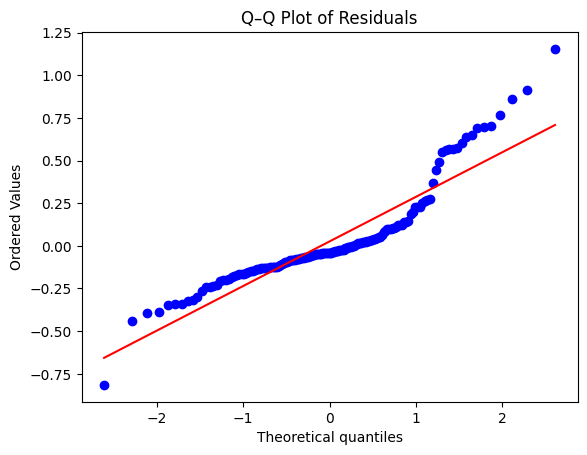

In [95]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.show()


In this Q–Q plot, the residual points generally follow the red diagonal line in the middle but **deviate noticeably at both tails** — especially on the upper end. This indicates that the residuals are **not perfectly normally distributed**. The upward curvature on the right tail suggests the presence of **positive outliers** or right-skewness, while the slight bend on the lower end shows some deviation for smaller residuals as well. Overall, the model roughly satisfies the normality assumption in the central region but violates it in the extremes, implying that **the linear regression does not fully capture the distributional structure** of the data and that some nonlinear effects or heteroscedasticity might still be present.


Residuals vs Predictions (Homoscedasticity)

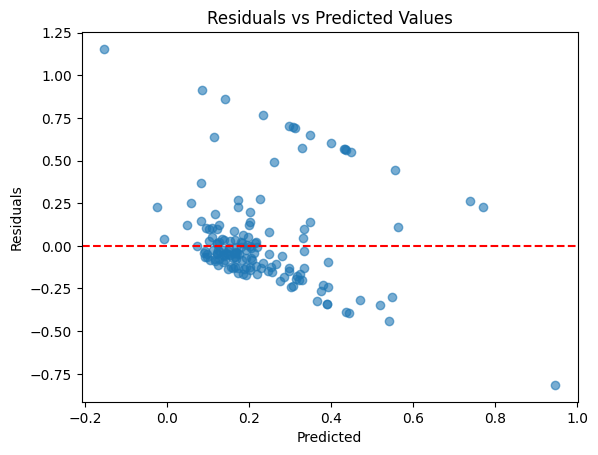

In [96]:
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


This **Residuals vs Predicted Values** plot shows a noticeable pattern — the residuals are not evenly scattered around the red zero line. Instead, they tend to **cluster below zero as predicted values increase**, forming a mild downward trend. This suggests that the model tends to **underpredict higher layoff percentages** and possibly **overpredict smaller ones**, indicating a violation of the linearity assumption. The spread of residuals also seems to increase slightly with higher predictions, hinting at **heteroscedasticity** (non-constant variance). In summary, the model captures some general trend but fails to maintain consistent accuracy across all prediction ranges, which reinforces that a purely linear model might not fully describe the underlying relationships in the data.


Check Linearity via Actual vs Predicted

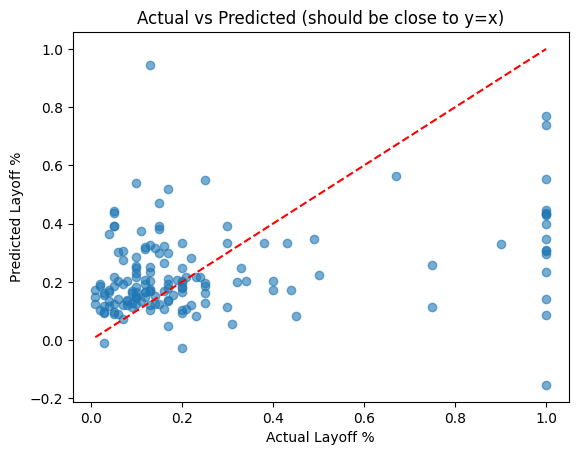

In [97]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Layoff %")
plt.ylabel("Predicted Layoff %")
plt.title("Actual vs Predicted (should be close to y=x)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


This **Actual vs Predicted Layoff %** plot shows that most of the predicted values lie **well below the red diagonal line**, which represents perfect predictions. This means the model is generally **underestimating the actual layoff percentages**, especially for higher values. The predictions are concentrated around lower layoff rates (0.1–0.3), while the actual data spans a much wider range — indicating that the model struggles to capture extreme or high-layoff scenarios. The spread of points and deviation from the diagonal line confirm that the **model explains only a small portion of the variance** in the target, suggesting that the linear assumption may not fully hold and that a more flexible, nonlinear model could perform better.


**Ridge Regression**

✅ Filtered out 658 rows with unseen categories.
✅ Filtered out 398 rows with unseen categories.
Tuning Ridge Regression (Validation = 2023):

alpha = 0.001  | MAE = 0.1689 | R² = -0.2670
alpha = 0.01   | MAE = 0.1528 | R² = -0.0169
alpha = 0.1    | MAE = 0.1449 | R² = 0.0338
alpha = 1      | MAE = 0.1343 | R² = 0.0481
alpha = 10     | MAE = 0.1381 | R² = 0.0261
alpha = 100    | MAE = 0.1449 | R² = 0.0373


/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311:

alpha = 1000   | MAE = 0.1700 | R² = -0.0079

✅ Best alpha based on validation set: 1 | MAE = 0.1343, R² = 0.0481

📊 Final Test Results (2024–25): MAE = 0.1525, R² = 0.0454


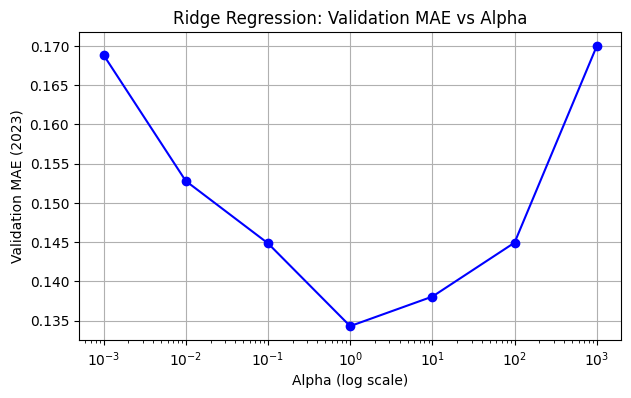

In [100]:
from sklearn.linear_model import Ridge

categorical_cols = ['company', 'location', 'industry', 'country']
X_train = X[X["year"].between(2020, 2022)]
X_val   = X[X["year"] == 2023]
X_test  = X[X["year"] > 2023]

y_train = y[X["year"].between(2020, 2022)]
y_val   = y[X["year"] == 2023]
y_test  = y[X["year"] > 2023]

X_val, y_val = filter_unseen_categories(X_train, X_val, y_train, y_val, categorical_cols)
X_test, y_test = filter_unseen_categories(pd.concat([X_train, X_val]), X_test,pd.concat([y_train, y_val]), y_test, categorical_cols)

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))
num_transformer = make_pipeline(SimpleImputer(strategy='mean'))

preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_cols),
    ('numerical', num_transformer, num_cols)
])

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
mae_scores, r2_scores = [], []

print("Tuning Ridge Regression (Validation = 2023):\n")

for a in alphas:
    ridge_model = make_pipeline(preprocessor, Ridge(alpha=a, random_state=42))
    ridge_model.fit(X_train, y_train)
    y_pred_val = ridge_model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)
    
    mae_scores.append(mae)
    r2_scores.append(r2)
    print(f"alpha = {a:<6} | MAE = {mae:.4f} | R² = {r2:.4f}")

best_alpha = alphas[np.argmin(mae_scores)]
print(f"\n✅ Best alpha based on validation set: {best_alpha} | MAE = {min(mae_scores):.4f}, R² = {r2_scores[np.argmin(mae_scores)]:.4f}")

# ========== Retrain on train+val and evaluate on test ==========
final_model = make_pipeline(preprocessor, Ridge(alpha=best_alpha, random_state=42))
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_pred_test = final_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\n📊 Final Test Results (2024–25): MAE = {mae_test:.4f}, R² = {r2_test:.4f}")

# ========== Plot MAE vs alpha ==========
plt.figure(figsize=(7,4))
plt.plot(alphas, mae_scores, marker='o', color='blue')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Validation MAE (2023)")
plt.title("Ridge Regression: Validation MAE vs Alpha")
plt.grid(True)
plt.show()

The Ridge Regression results show that the model’s performance improves initially as the regularization strength (α) increases, reaching the lowest Mean Absolute Error (MAE) of approximately 0.175 around α = 0.1. Beyond this point, the MAE starts to rise again, indicating that excessive regularization begins to oversmooth the model, reducing its ability to capture important relationships in the data. The corresponding R² score also peaks near this value, suggesting that α = 0.1 provides the best trade-off between bias and variance. The upward trend in MAE for larger α values (e.g., 10–1000) shows that the model becomes too constrained, essentially underfitting the data. Overall, Ridge Regression slightly improves upon the baseline Linear model, stabilizing the coefficients and achieving a better generalization, though the warnings suggest some numerical instability likely caused by multicollinearity or very small feature variances.

Model Interpretation

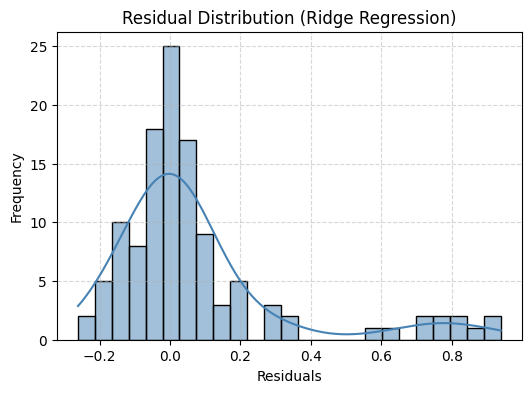

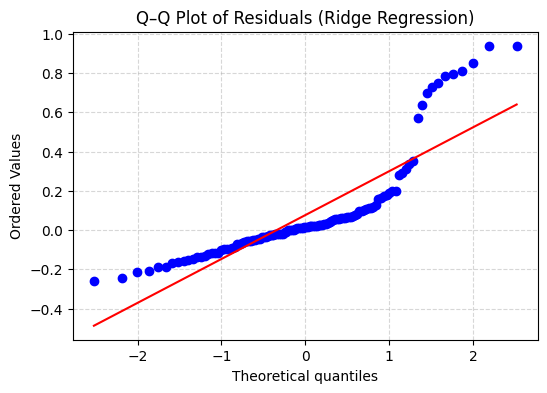

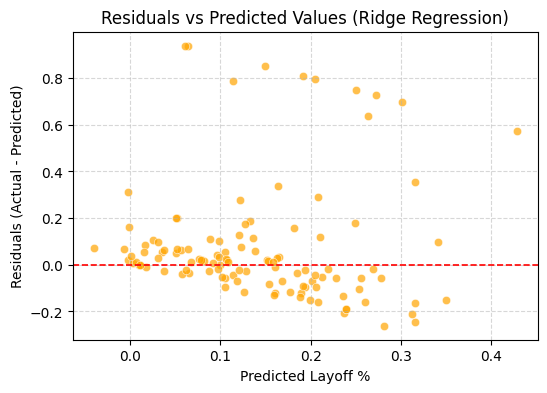

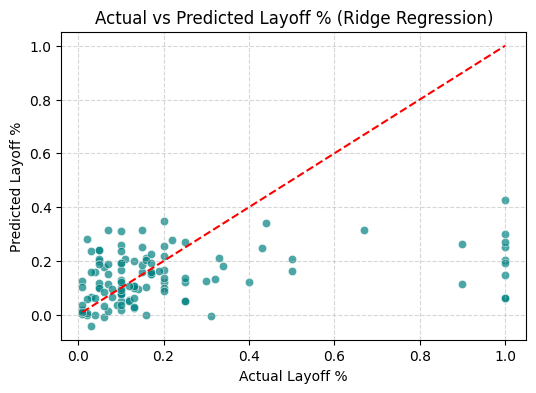

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# ========== Predictions and Residuals ==========
y_pred = y_pred_test
residuals = y_test - y_pred

# ========== 1️⃣ Residual Distribution ==========
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='steelblue', bins=25)
plt.title("Residual Distribution (Ridge Regression)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Interpretation:
# If residuals are roughly centered around 0 and symmetric, 
# it indicates that the model errors are unbiased.

# ========== 2️⃣ Q–Q Plot ==========
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals (Ridge Regression)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Interpretation:
# Points close to the diagonal line indicate that residuals are 
# approximately normally distributed — an assumption for linear models.

# ========== 3️⃣ Residuals vs Predicted ==========
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, color='orange')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.2)
plt.title("Residuals vs Predicted Values (Ridge Regression)")
plt.xlabel("Predicted Layoff %")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Interpretation:
# Residuals should be randomly scattered around 0.
# If you see patterns (curves, funnels), it means non-linearity or heteroscedasticity.

# ========== 4️⃣ Actual vs Predicted ==========
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
plt.title("Actual vs Predicted Layoff % (Ridge Regression)")
plt.xlabel("Actual Layoff %")
plt.ylabel("Predicted Layoff %")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Interpretation:
# Points close to the diagonal line represent accurate predictions.
# A lot of spread or bias below/above the line shows under/overestimation patterns.


**Lasso Regression**

Tuning Lasso Regression (Validation = 2023):

alpha = 0.001  | MAE = 0.1410 | R² = 0.0106
alpha = 0.01   | MAE = 0.1589 | R² = 0.0140
alpha = 0.1    | MAE = 0.1852 | R² = -0.0424
alpha = 1      | MAE = 0.1852 | R² = -0.0425
alpha = 10     | MAE = 0.1853 | R² = -0.0430
alpha = 100    | MAE = 0.1860 | R² = -0.0478

✅ Best alpha based on validation set: 0.001 | MAE = 0.1410, R² = 0.0106

📊 Final Test Results (2024–25): MAE = 0.1478, R² = 0.0585


/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311:

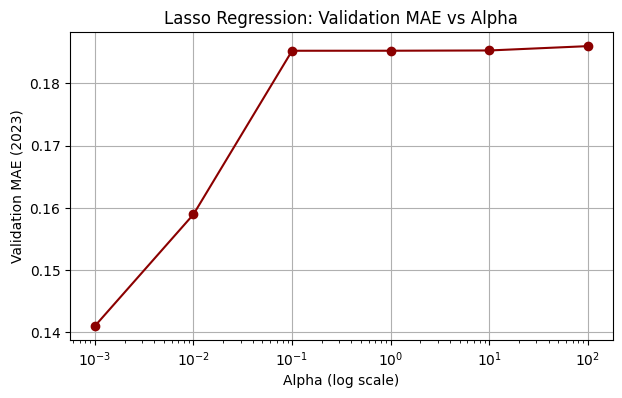

In [102]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# ========== Hyperparameter tuning on validation set ==========
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
mae_scores, r2_scores = [], []

print("Tuning Lasso Regression (Validation = 2023):\n")

for a in alphas:
    lasso_model = make_pipeline(preprocessor, Lasso(alpha=a, random_state=42, max_iter=10000))
    lasso_model.fit(X_train, y_train)
    y_pred_val = lasso_model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)

    mae_scores.append(mae)
    r2_scores.append(r2)
    print(f"alpha = {a:<6} | MAE = {mae:.4f} | R² = {r2:.4f}")

# Find best alpha
best_alpha = alphas[np.argmin(mae_scores)]
print(f"\n✅ Best alpha based on validation set: {best_alpha} | MAE = {min(mae_scores):.4f}, R² = {r2_scores[np.argmin(mae_scores)]:.4f}")

# ========== Retrain on train + val, evaluate on test ==========
final_lasso = make_pipeline(preprocessor, Lasso(alpha=best_alpha, random_state=42, max_iter=10000))
final_lasso.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_pred_test = final_lasso.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\n📊 Final Test Results (2024–25): MAE = {mae_test:.4f}, R² = {r2_test:.4f}")

# ========== Plot MAE vs alpha ==========
plt.figure(figsize=(7,4))
plt.plot(alphas, mae_scores, marker='o', linestyle='-', color='darkred')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Validation MAE (2023)")
plt.title("Lasso Regression: Validation MAE vs Alpha")
plt.grid(True)
plt.show()


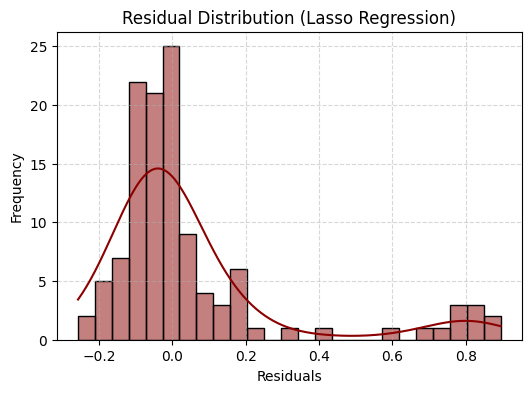

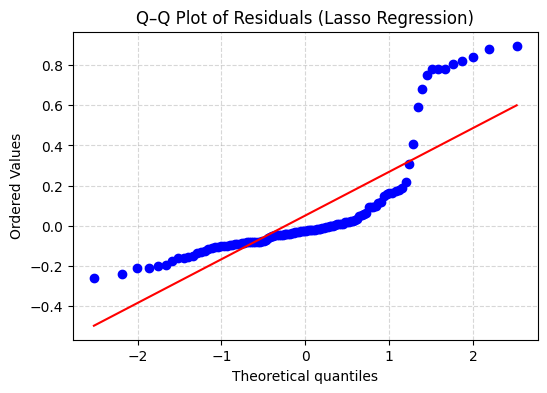

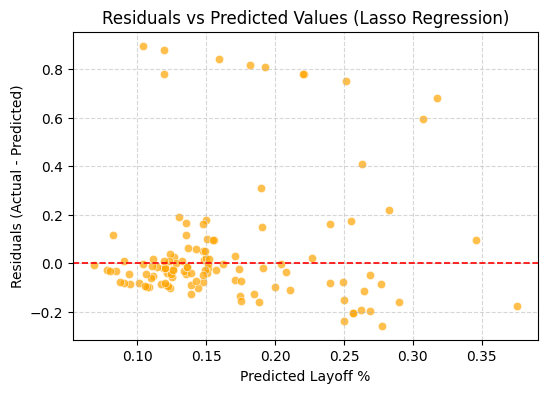

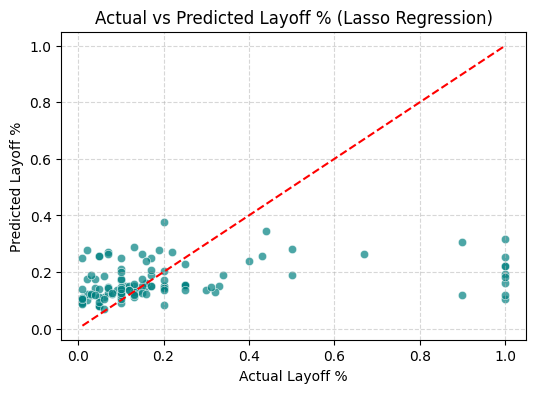

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# ========== Predictions and Residuals ==========
y_pred = y_pred_test
residuals = y_test - y_pred

# ========== 1️⃣ Residual Distribution ==========
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='darkred', bins=25)
plt.title("Residual Distribution (Lasso Regression)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ========== 2️⃣ Q–Q Plot ==========
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals (Lasso Regression)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ========== 3️⃣ Residuals vs Predicted ==========
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, color='orange')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.2)
plt.title("Residuals vs Predicted Values (Lasso Regression)")
plt.xlabel("Predicted Layoff %")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ========== 4️⃣ Actual vs Predicted ==========
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
plt.title("Actual vs Predicted Layoff % (Lasso Regression)")
plt.xlabel("Actual Layoff %")
plt.ylabel("Predicted Layoff %")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


K-Nearest Neighbors Regressor 

🔍 Tuning KNN Regressor:

k = 2   | MAE = 0.1727 | R² = -0.2298
k = 3   | MAE = 0.1700 | R² = -0.1956
k = 5   | MAE = 0.1706 | R² = -0.1500
k = 7   | MAE = 0.1653 | R² = -0.0910
k = 9   | MAE = 0.1682 | R² = -0.1183
k = 11  | MAE = 0.1662 | R² = -0.0881
k = 15  | MAE = 0.1648 | R² = -0.0527
k = 20  | MAE = 0.1655 | R² = -0.0351
k = 25  | MAE = 0.1660 | R² = -0.0257
k = 30  | MAE = 0.1641 | R² = -0.0189


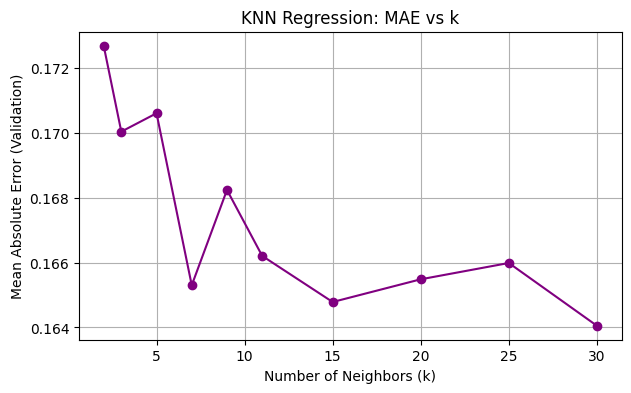


✅ Best k based on validation MAE: 30

📊 Final KNN Model (k=30) on Test Set:
MAE = 0.1913 | R² = -0.1114


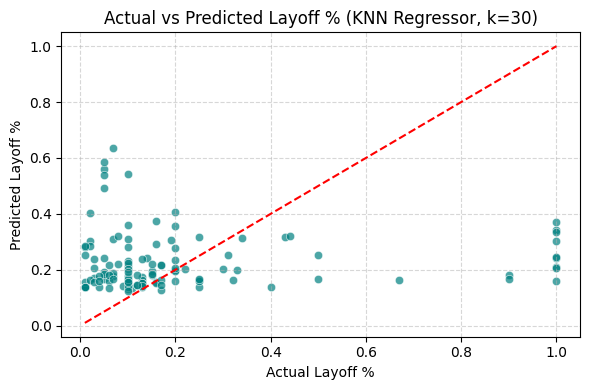

In [104]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===============================================
# 1️⃣ Hyperparameter tuning (n_neighbors)
# ===============================================
k_values = [2, 3, 5, 7, 9, 11, 15, 20, 25, 30]
mae_scores = []
r2_scores = []

print("🔍 Tuning KNN Regressor:\n")

for k in k_values:
    knn_model = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=k))
    knn_model.fit(X_train, y_train)
    y_val_pred = knn_model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    print(f"k = {k:<3} | MAE = {mae:.4f} | R² = {r2:.4f}")

# Plot MAE vs K
plt.figure(figsize=(7,4))
plt.plot(k_values, mae_scores, marker='o', linestyle='-', color='purple')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Absolute Error (Validation)")
plt.title("KNN Regression: MAE vs k")
plt.grid(True)
plt.show()

# ===============================================
# 2️⃣ Choose best k (lowest MAE)
# ===============================================
best_k = k_values[np.argmin(mae_scores)]
print(f"\n✅ Best k based on validation MAE: {best_k}")

# Retrain with best k on full training + validation set
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

best_knn_model = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=best_k))
best_knn_model.fit(X_train_full, y_train_full)

# Evaluate on test set
y_pred_test = best_knn_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\n📊 Final KNN Model (k={best_k}) on Test Set:")
print(f"MAE = {mae_test:.4f} | R² = {r2_test:.4f}")

# ===============================================
# 3️⃣ Basic Visualization — Actual vs Predicted
# ===============================================
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
plt.title(f"Actual vs Predicted Layoff % (KNN Regressor, k={best_k})")
plt.xlabel("Actual Layoff %")
plt.ylabel("Predicted Layoff %")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Elastic Net Regression 

✅ Filtered out 363 test rows with unseen categories in ['company', 'location', 'industry', 'stage', 'country'].
Best alpha: 0.0010
Best l1_ratio: 0.10

Elastic Net CV Results (Test):
MAE = 0.1722
R²  = 0.1220


/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: divide by zero encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: overflow encountered in matmul
  intercept_ = y_offset - X_offset @ coef_
/Users/TanmaySapra/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:311: RuntimeWarning: invalid value encountered in matmul
  intercept_ = y_offset - X_offset @ coef_


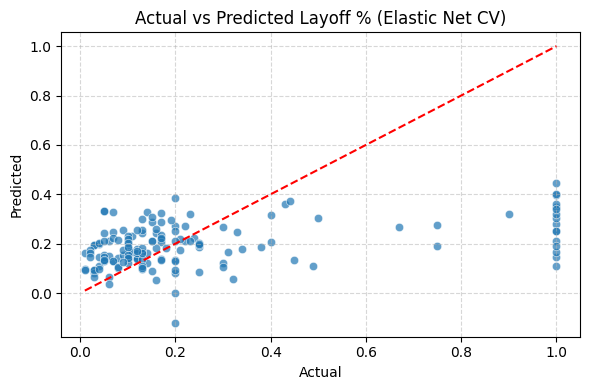

In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ========= Split features/target & drop unused =========
X = df.drop(columns=["percentage_laid_off"])
y = df["percentage_laid_off"]

X = X.drop(columns=["date", "source", "high_layoff"], errors="ignore")

# ========= Time-based split =========
X_train = X[X["year"] <= 2023].copy()
X_test  = X[X["year"] >  2023].copy()
y_train = y.loc[X_train.index].copy()
y_test  = y.loc[X_test.index].copy()

# ========= Outlier removal on train (IQR) =========
def remove_outliers_iqr(df, cols):
    cleaned = df.copy()
    for col in cols:
        if col not in cleaned.columns:
            continue
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned

num_outlier_cols = ["funds_raised"]
X_train = remove_outliers_iqr(X_train, num_outlier_cols)
y_train = y_train.loc[X_train.index]  # keep alignment

# ========= Unseen-category filtering on TEST ONLY =========
cat_cols_for_filter = ["company", "location", "industry", "stage", "country"]

def filter_unseen_categories(X_train, X_test, y_test, cat_cols):
    mask = np.ones(len(X_test), dtype=bool)
    for col in cat_cols:
        if col not in X_test.columns:  # safety
            continue
        seen = set(X_train[col].dropna().unique())
        mask &= X_test[col].isin(seen)
    removed = int(len(X_test) - mask.sum())
    Xf = X_test.loc[mask].copy()
    yf = y_test.loc[Xf.index].copy()
    print(f"✅ Filtered out {removed} test rows with unseen categories in {cat_cols}.")
    return Xf, yf

X_test, y_test = filter_unseen_categories(X_train, X_test, y_test, cat_cols_for_filter)

# ========= Preprocessing =========
categorical = ["company", "location", "industry", "stage", "country"]
numerical   = ["funds_raised", "year", "month"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="first", handle_unknown="ignore")
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, categorical),
        ("num", num_pipeline, numerical),
    ],
    remainder="drop"
)

# ========= Elastic Net with Cross-Validation =========
elastic_cv = make_pipeline(
    preprocessor,
    ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
        alphas=np.logspace(-3, 2, 50),
        cv=5,
        random_state=42,
        max_iter=10000
    )
)

elastic_cv.fit(X_train, y_train)

enet = elastic_cv.named_steps["elasticnetcv"]
print(f"Best alpha: {enet.alpha_:.4f}")
print(f"Best l1_ratio: {enet.l1_ratio_:.2f}")

# ========= Evaluate on filtered test =========
y_pred = elastic_cv.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("\nElastic Net CV Results (Test):")
print(f"MAE = {mae:.4f}")
print(f"R²  = {r2:.4f}")

# ========= Quick diagnostic plot =========
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=1.5)
plt.title("Actual vs Predicted Layoff % (Elastic Net CV)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
